## defining the libaries

In [233]:
import jax 
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft
from jax import grad,jit
import optax


## define the Allen-cahn parameters

In [234]:
L = 1 #Length 
Nx = 128 #number of grid point
dx = L/128 # spacing the griding points 
epsilon = 0.01
dt = 0.01 # time step or time increment

## define spatial grid

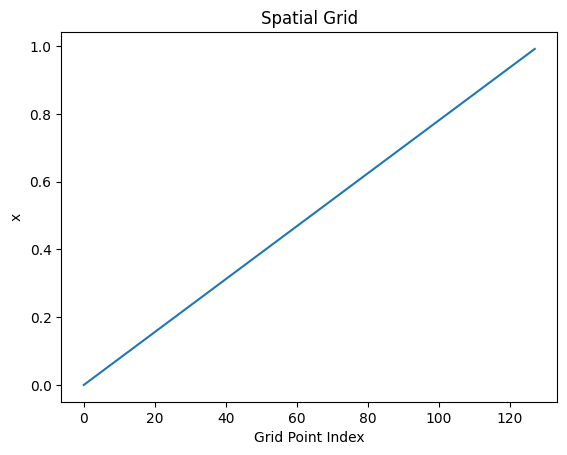

In [235]:
x = jnp.linspace(0, L, Nx, endpoint = False)
import matplotlib.pyplot as plt

plt.plot(x)
plt.title("Spatial Grid")
plt.xlabel("Grid Point Index")
plt.ylabel("x")
plt.show()


 ## Initialize the phase field

In [236]:
def initialize_phase_field():
    return jnp.sin(2 * jnp.pi * x) + 0.01 * jax.random.normal(jax.random.PRNGKey(0), (Nx,))

### Fourier Neural Opertor Component

In [237]:
class FourierLayer:
    def __init__ (self, modes):
        self.modes = modes
        self.weight = jax.random.normal(jax.random.PRNGKey(0), (modes, 2))


    def __call__ (self, u):
        # forward fourier transform
        u_hat = fft(u)
        # Apply learnable weight in Fourier space
        u_hat = u_hat.at[:self.modes].set(u_hat[:self.modes] * self.weights[:, 0] + 1j * self.weights[:, 1])
        # Inverse Fourier transform
        return jnp.real(ifft(u_hat))
    
class FNO:
    def __init__ (self, modes, width):
        self.fourier_layer = FourierLayer(modes)
        self.linear = jax.random.normal(jax.random.PRNGKey(1), (Nx, width))

    def __call__(self, u):
        u = self.fourier_layer(u)
        u = jnp.dot(u, self.linear)
        return jnp.tanh(u)


    




## Loss function

In [238]:
def supervised_loss(u_pred, u_true):
    return jnp.mean((u_pred - u_true) ** 2)

def physics_loss(u, u_t, epsilon):
    u_xx = jnp.gradient(jnp.gradient(u, dx), dx)
    residual = u_t - epsilon**2 * u_xx + u**3 -u
    return jnp.mean(residual**2)

## Training

In [239]:


def train_step(params, optimizer, opt_state, u_init, u_true, epsilon, dt):
    def loss_fn(params):
        u_pred = FNO(params['modes'], params['width'])(u_init)
        u_t = (u_pred - u_init) / dt
        loss = supervised_loss(u_pred, u_true) + 1e-3 * physics_loss(u_pred, u_t, epsilon)
        return jnp.float32(loss)
    
    
    # params = {'modes': 16.0, 'width': 64.0 }
    grads = grad(loss_fn)({'modes': 16, 'width': 64})
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


## Hyperparameters

In [240]:
params = {'modes': 16, 'width': 64 }
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

## Simulate data

In [241]:
# fno = FNO(params['modes'], params['width'])

u_init = initialize_phase_field()
u_true = u_init # repalce with ground truth from solver
u_init = jnp.array(u_init, dtype=jnp.float32)
u_true = jnp.array(u_true, dtype=jnp.float32)

dt = 0.01 # time step
# print(u_init)
# print(u_true)
# print(dt)

## Training Loop

In [242]:

for ep in range(1000):
    params, opt_state = train_step(params, optimizer, opt_state, u_init, u_true, epsilon, dt)
    if ep % 100 == 0:
        print(f"Epoch {ep}: Loss computed.")


TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

In [245]:
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft
from jax import grad, jit, vmap
import optax

# Define the Allen-Cahn parameters
L = 1.0  # Domain length
Nx = 128  # Number of grid points
dx = L / Nx
epsilon = 0.01

# Define spatial grid
x = jnp.linspace(0, L, Nx, endpoint=False)

# Initialize the phase field
def initialize_phase_field():
    return jnp.sin(2 * jnp.pi * x) + 0.1 * jax.random.normal(jax.random.PRNGKey(0), (Nx,))

# Fourier Neural Operator Components
class FourierLayer:
    def __init__(self, modes):
        self.modes = modes
        # Use JAX to generate weights
        self.weights = jax.random.normal(jax.random.PRNGKey(0), (modes, 2), dtype=jnp.float32)

    def __call__(self, u):
        # Forward Fourier transform
        u_hat = fft(u)
        # Apply learnable weights in Fourier space
        u_hat = u_hat.at[:self.modes].set(u_hat[:self.modes] * self.weights[:, 0] + 1j * self.weights[:, 1])
        # Inverse Fourier transform
        return jnp.real(ifft(u_hat))

class FNO:
    def __init__(self, modes, width):
        self.fourier_layer = FourierLayer(modes)
        # Initialize linear weights using JAX
        self.linear = jax.random.normal(jax.random.PRNGKey(1), (Nx, width), dtype=jnp.float32)

    def __call__(self, u):
        u = self.fourier_layer(u)
        u = jnp.dot(u, self.linear)
        return jnp.tanh(u)

# Loss functions
def supervised_loss(u_pred, u_true):
    return jnp.mean((u_pred - u_true) ** 2)

def physics_loss(u, u_t, epsilon):
    u_xx = jnp.gradient(jnp.gradient(u, dx), dx)
    residual = u_t - epsilon**2 * u_xx + u**3 - u
    return jnp.mean(residual**2)

# Training
@jit
def train_step(params, optimizer, opt_state, u_init, u_true, epsilon, dt):
    def loss_fn(params):
        # Ensure the modes and width are taken as jnp arrays when used in FNO
        fno = FNO(params['modes'], params['width'])
        u_pred = fno(u_init)
        u_t = (u_pred - u_init) / dt
        loss = supervised_loss(u_pred, u_true) + 1e-3 * physics_loss(u_pred, u_t, epsilon)
        return loss

    grads = grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Hyperparameters
params = {'modes': jnp.array(16, dtype=jnp.int32), 'width': jnp.array(64, dtype=jnp.int32)}
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

# Simulate data
u_init = initialize_phase_field()
u_true = u_init  # Replace with ground truth from a solver
dt = 0.01  # Time step

# Training loop
for epoch in range(1000):
    params, opt_state = train_step(params, optimizer, opt_state, u_init, u_true, epsilon, dt)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss computed.")


TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute